# Multi agent non cooperative repeated experiment with pure strategies and static environment

In this setup, we will consider tasks being assigned to 4 agents:  
* 1 Requesters
* 1 dApp providers
* 1 Data providers
* 1 Computing providers

Some agents will randomly be set as malicious whereas others will be considered honest.  

When a malicious agent takes part in a task, we consider that the task fails.  

We'll try implementing a staking system where everyone is slashed if the task fail, then we'll incrementaly improve that system so that it punishes the most malicious actors and doesn't penalize honest actors too much.  

If an actor's stacking pool is empty after being slashed too many times, it is banned from the network and cannot take part in tasks anymore.

## Basic functions

In [11]:
import random
import matplotlib.pyplot as plt

In [12]:
# Constants
NUM_REQUESTERS = 100
NUM_DAPP_PROVIDERS = 100
NUM_DATA_PROVIDERS = 100
NUM_COMPUTING_PROVIDERS = 100
TOTAL_TASKS = 50000
STAKE_AMOUNT = 1000  # Amount needed to be staked in RLC

SLASH_PERCENT_REQUESTER = 0.05
SLASH_PERCENT_DAPP_PROVIDER = 0.05
SLASH_PERCENT_DATA_PROVIDER = 0.05
SLASH_PERCENT_COMPUTING_PROVIDER = 0.05

REWARD_PERCENT_REQUESTER = 0.01
REWARD_PERCENT_DAPP_PROVIDER = 0.01
REWARD_PERCENT_DATA_PROVIDER = 0.01
REWARD_PERCENT_COMPUTING_PROVIDER = 0.01

MALICIOUS_REQUESTER_RATIO = 0.3
MALICIOUS_DAPP_PROVIDER_RATIO = 0.3
MALICIOUS_DATA_PROVIDER_RATIO = 0.3
MALICIOUS_COMPUTING_PROVIDER_RATIO = 0.3

## Constant slashing ratio setup

Here we are slashing a fixed ratio of the task price to everyone everytime they are involved in a failed task. We can see that we successfuly neutralize malicious actors over time, but we also neutralize some honest actors, and honest actors loose a lot of money in the process.

BANNED DAPP PROVIDER: Agent ID: 98, Stake Pool: -3.949999999999834, Malicious: True
BANNED REQUESTER: Agent ID: 26, Stake Pool: -3.912500000000472, Malicious: True
BANNED REQUESTER: Agent ID: 56, Stake Pool: -1.324999999999899, Malicious: True
BANNED REQUESTER: Agent ID: 88, Stake Pool: -2.52499999999963, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 16, Stake Pool: -4.399999999999839, Malicious: True
BANNED DAPP PROVIDER: Agent ID: 42, Stake Pool: -2.787500000000005, Malicious: True
BANNED DATA PROVIDER: Agent ID: 15, Stake Pool: -3.012500000000715, Malicious: True
BANNED DATA PROVIDER: Agent ID: 17, Stake Pool: -1.9249999999998013, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 59, Stake Pool: -1.7000000000003257, Malicious: True
BANNED DAPP PROVIDER: Agent ID: 43, Stake Pool: -0.42500000000008686, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 25, Stake Pool: -0.6500000000000732, Malicious: True
BANNED REQUESTER: Agent ID: 49, Stake Pool: -0.23750000000007043, Mal

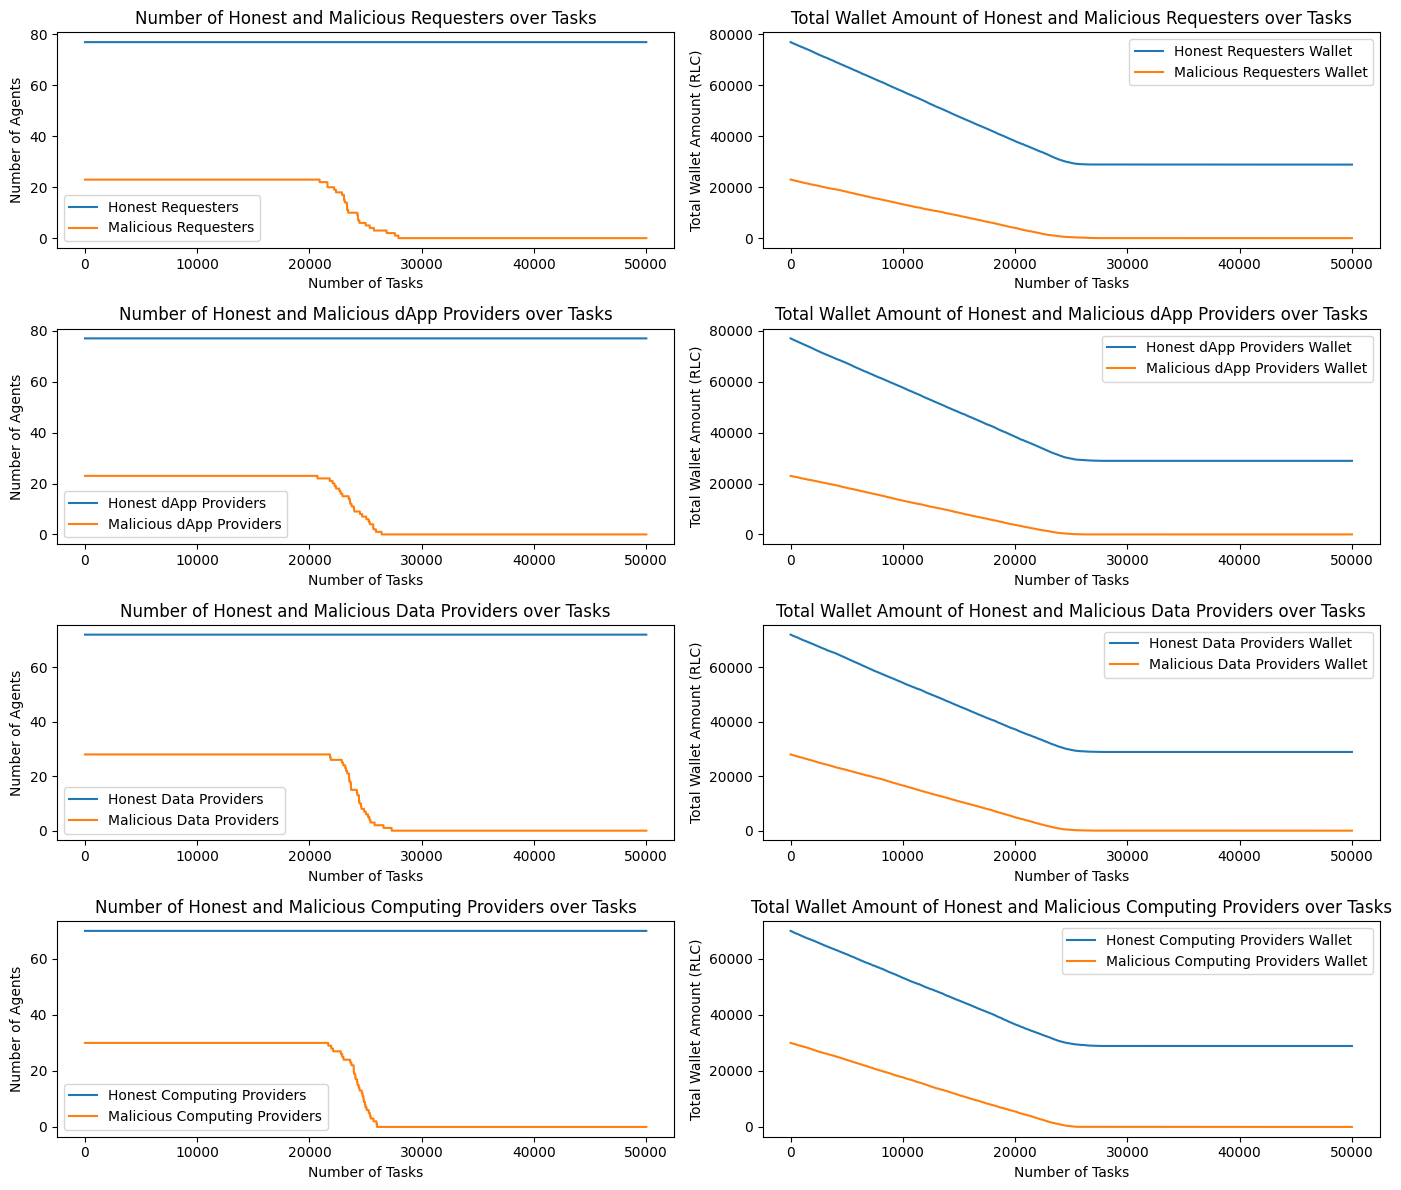

In [13]:
# Function to simulate a task round
def simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):

    # Check if pools are not empty
    if not requesters or not dapp_providers or not data_providers or not computing_providers:
        return False  # No task can be performed if any pool is empty

    # Randomly assign one agent from each pool to form a task group
    requester = random.choice(requesters)
    dapp_provider = random.choice(dapp_providers)
    data_provider = random.choice(data_providers)
    computing_provider = random.choice(computing_providers)

    # Determine prices randomly (1 to 100 RLC)
    dapp_price = random.randint(10, 100)
    data_price = random.randint(10, 100)
    computing_price = (dapp_price + data_price) * 0.75

    # Check if any agent in the task group is malicious
    task_failed = any(agent.is_malicious for agent in [requester, dapp_provider, data_provider, computing_provider])

    if task_failed:
        # Calculate slashing amounts
        total_order_price = dapp_price + data_price + computing_price
        slash_amount_requester = SLASH_PERCENT_REQUESTER * computing_price
        slash_amount_dapp_provider = SLASH_PERCENT_DAPP_PROVIDER * computing_price
        slash_amount_data_provider = SLASH_PERCENT_DATA_PROVIDER * computing_price
        slash_amount_computing_provider = SLASH_PERCENT_COMPUTING_PROVIDER * computing_price

        # Slash the agents
        requester.stake_pool -=  slash_amount_requester
        dapp_provider.stake_pool -= slash_amount_dapp_provider
        data_provider.stake_pool -= slash_amount_data_provider
        computing_provider.stake_pool -= slash_amount_computing_provider

        # Check if any agent's stake pool is empty
        if requester.stake_pool <= 0:
            print(f"BANNED REQUESTER: {requester.print_info()}")
            requesters.remove(requester)
        if dapp_provider.stake_pool <= 0:
            print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
            dapp_providers.remove(dapp_provider)
        if data_provider.stake_pool <= 0:
            print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
            data_providers.remove(data_provider)
        if computing_provider.stake_pool <= 0:
            print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
            computing_providers.remove(computing_provider)

    # Computing provider is not slashed but incurs the cost of computation as a penalty

    # Return the result of the task (success or failure)
    return not task_failed

# Define classes for agents
class Agent:
    def __init__(self, id, stake_pool, is_malicious):
        self.id = id
        self.stake_pool = stake_pool
        self.is_malicious = is_malicious

    def print_info(self):
        return f"Agent ID: {self.id}, Stake Pool: {self.stake_pool}, Malicious: {self.is_malicious}"

# Initialize pools of agents
requesters = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_REQUESTER_RATIO) for i in range(NUM_REQUESTERS)]
dapp_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DAPP_PROVIDER_RATIO) for i in range(NUM_DAPP_PROVIDERS)]
data_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DATA_PROVIDER_RATIO) for i in range(NUM_DATA_PROVIDERS)]
computing_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_COMPUTING_PROVIDER_RATIO) for i in range(NUM_COMPUTING_PROVIDERS)]

# Track counts of honest and malicious actors over time
task_counts = list(range(1, TOTAL_TASKS + 1))
honest_requesters_count = []
malicious_requesters_count = []
honest_dapp_providers_count = []
malicious_dapp_providers_count = []
honest_data_providers_count = []
malicious_data_providers_count = []
honest_computing_providers_count = []
malicious_computing_providers_count = []

# Track wallet amounts of honest and malicious actors over time
honest_requesters_wallet = []
malicious_requesters_wallet = []
honest_dapp_providers_wallet = []
malicious_dapp_providers_wallet = []
honest_data_providers_wallet = []
malicious_data_providers_wallet = []
honest_computing_providers_wallet = []
malicious_computing_providers_wallet = []

# Simulate tasks
successful_tasks = 0
for _ in range(TOTAL_TASKS):
    # Count initial number of honest and malicious actors
    honest_requesters = sum(1 for requester in requesters if not requester.is_malicious)
    malicious_requesters = sum(1 for requester in requesters if requester.is_malicious)
    honest_dapp_providers = sum(1 for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    malicious_dapp_providers = sum(1 for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    honest_data_providers = sum(1 for data_provider in data_providers if not data_provider.is_malicious)
    malicious_data_providers = sum(1 for data_provider in data_providers if data_provider.is_malicious)
    honest_computing_providers = sum(1 for computing_provider in computing_providers if not computing_provider.is_malicious)
    malicious_computing_providers = sum(1 for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_count.append(honest_requesters)
    malicious_requesters_count.append(malicious_requesters)
    honest_dapp_providers_count.append(honest_dapp_providers)
    malicious_dapp_providers_count.append(malicious_dapp_providers)
    honest_data_providers_count.append(honest_data_providers)
    malicious_data_providers_count.append(malicious_data_providers)
    honest_computing_providers_count.append(honest_computing_providers)
    malicious_computing_providers_count.append(malicious_computing_providers)

    # Track total wallet amounts
    total_wallet_honest_requesters = sum(requester.stake_pool for requester in requesters if not requester.is_malicious)
    total_wallet_malicious_requesters = sum(requester.stake_pool for requester in requesters if requester.is_malicious)
    total_wallet_honest_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    total_wallet_malicious_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    total_wallet_honest_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if not data_provider.is_malicious)
    total_wallet_malicious_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if data_provider.is_malicious)
    total_wallet_honest_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if not computing_provider.is_malicious)
    total_wallet_malicious_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_wallet.append(total_wallet_honest_requesters)
    malicious_requesters_wallet.append(total_wallet_malicious_requesters)
    honest_dapp_providers_wallet.append(total_wallet_honest_dapp_providers)
    malicious_dapp_providers_wallet.append(total_wallet_malicious_dapp_providers)
    honest_data_providers_wallet.append(total_wallet_honest_data_providers)
    malicious_data_providers_wallet.append(total_wallet_malicious_data_providers)
    honest_computing_providers_wallet.append(total_wallet_honest_computing_providers)
    malicious_computing_providers_wallet.append(total_wallet_malicious_computing_providers)

    if simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):
        successful_tasks += 1

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Plot results
plt.figure(figsize=(14, 12))

plt.subplot(421)
plt.plot(task_counts, honest_requesters_count, label='Honest Requesters')
plt.plot(task_counts, malicious_requesters_count, label='Malicious Requesters')
plt.title('Number of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(422)
plt.plot(task_counts, honest_requesters_wallet, label='Honest Requesters Wallet')
plt.plot(task_counts, malicious_requesters_wallet, label='Malicious Requesters Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(423)
plt.plot(task_counts, honest_dapp_providers_count, label='Honest dApp Providers')
plt.plot(task_counts, malicious_dapp_providers_count, label='Malicious dApp Providers')
plt.title('Number of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(424)
plt.plot(task_counts, honest_dapp_providers_wallet, label='Honest dApp Providers Wallet')
plt.plot(task_counts, malicious_dapp_providers_wallet, label='Malicious dApp Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(425)
plt.plot(task_counts, honest_data_providers_count, label='Honest Data Providers')
plt.plot(task_counts, malicious_data_providers_count, label='Malicious Data Providers')
plt.title('Number of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(426)
plt.plot(task_counts, honest_data_providers_wallet, label='Honest Data Providers Wallet')
plt.plot(task_counts, malicious_data_providers_wallet, label='Malicious Data Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(427)
plt.plot(task_counts, honest_computing_providers_count, label='Honest Computing Providers')
plt.plot(task_counts, malicious_computing_providers_count, label='Malicious Computing Providers')
plt.title('Number of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(428)
plt.plot(task_counts, honest_computing_providers_wallet, label='Honest Computing Providers Wallet')
plt.plot(task_counts, malicious_computing_providers_wallet, label='Malicious Computing Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.tight_layout()
plt.show()

## Incremental slashing ratio setup

In this setup, we will slash an increasingly larger amount to repeated offender. For that the slashing amount will be based on the size of the slash pool left. The smaller the slash pool, the bigger the slash will be.  
We are getting encouraging results, we are now getting rid of our malicious users way faster and as a result, the honest user loose less money, with the 80% honest users loosing as much total money as the 20% malicious users. Resulting in an honest user loosing 250 RLC in average while a malicious user looses 1000 RLC in average. 

BANNED DAPP PROVIDER: Agent ID: 54, Stake Pool: -33.848088506165624, Malicious: True
BANNED REQUESTER: Agent ID: 15, Stake Pool: -75.4096819503299, Malicious: True
BANNED REQUESTER: Agent ID: 20, Stake Pool: -48.34498041219179, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 11, Stake Pool: -9.144588100065398, Malicious: True
BANNED DATA PROVIDER: Agent ID: 97, Stake Pool: -48.304342257489125, Malicious: True
BANNED DAPP PROVIDER: Agent ID: 90, Stake Pool: -118.52054268171813, Malicious: True
BANNED DAPP PROVIDER: Agent ID: 49, Stake Pool: -83.90871053912343, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 57, Stake Pool: -13.36550940692345, Malicious: True
BANNED DATA PROVIDER: Agent ID: 87, Stake Pool: -27.864934941668437, Malicious: True
BANNED REQUESTER: Agent ID: 54, Stake Pool: -32.157253038314764, Malicious: True
BANNED DAPP PROVIDER: Agent ID: 60, Stake Pool: -4.184910875486082, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 77, Stake Pool: -15.925578279858136, 

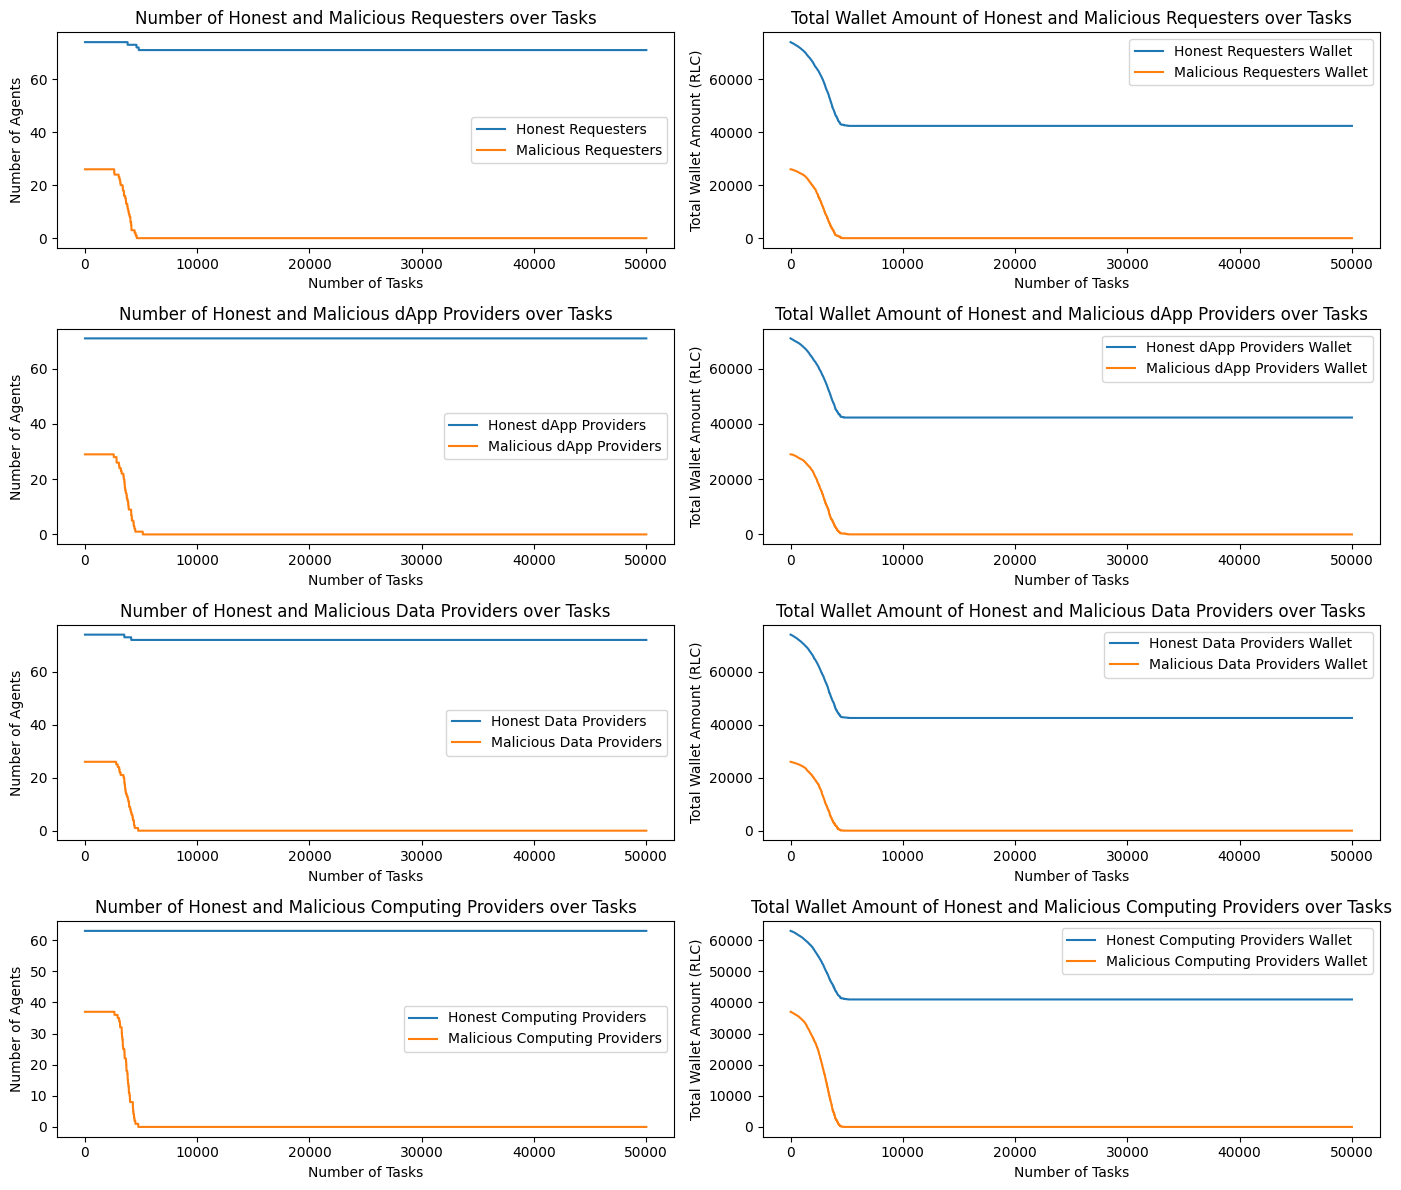

In [14]:
# Function to simulate a task round
def simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):

    # Check if pools are not empty
    if not requesters or not dapp_providers or not data_providers or not computing_providers:
        return False  # No task can be performed if any pool is empty

    # Randomly assign one agent from each pool to form a task group
    requester = random.choice(requesters)
    dapp_provider = random.choice(dapp_providers)
    data_provider = random.choice(data_providers)
    computing_provider = random.choice(computing_providers)

    # Determine prices randomly (1 to 100 RLC)
    dapp_price = random.randint(10, 100)
    data_price = random.randint(10, 100)
    computing_price = (dapp_price + data_price) * 0.75

    # Check if any agent in the task group is malicious
    task_failed = any(agent.is_malicious for agent in [requester, dapp_provider, data_provider, computing_provider])

    if task_failed:
        # Calculate slashing amounts
        total_order_price = dapp_price + data_price + computing_price
        slash_amount_requester = ( (STAKE_AMOUNT - requester.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_REQUESTER ) * computing_price
        slash_amount_dapp_provider = ( (STAKE_AMOUNT - dapp_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DAPP_PROVIDER ) * computing_price
        slash_amount_data_provider = ( (STAKE_AMOUNT - data_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DATA_PROVIDER ) * computing_price
        slash_amount_computing_provider = ( (STAKE_AMOUNT - computing_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_COMPUTING_PROVIDER ) * computing_price

        # Slash the agents
        requester.stake_pool -=  slash_amount_requester
        dapp_provider.stake_pool -= slash_amount_dapp_provider
        data_provider.stake_pool -= slash_amount_data_provider
        computing_provider.stake_pool -= slash_amount_computing_provider

        # Check if any agent's stake pool is empty
        if requester.stake_pool <= 0:
            print(f"BANNED REQUESTER: {requester.print_info()}")
            requesters.remove(requester)
        if dapp_provider.stake_pool <= 0:
            print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
            dapp_providers.remove(dapp_provider)
        if data_provider.stake_pool <= 0:
            print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
            data_providers.remove(data_provider)
        if computing_provider.stake_pool <= 0:
            print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
            computing_providers.remove(computing_provider)

    # Computing provider is not slashed but incurs the cost of computation as a penalty

    # Return the result of the task (success or failure)
    return not task_failed

# Define classes for agents
class Agent:
    def __init__(self, id, stake_pool, is_malicious):
        self.id = id
        self.stake_pool = stake_pool
        self.is_malicious = is_malicious

    def print_info(self):
        return f"Agent ID: {self.id}, Stake Pool: {self.stake_pool}, Malicious: {self.is_malicious}"

# Initialize pools of agents
requesters = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_REQUESTER_RATIO) for i in range(NUM_REQUESTERS)]
dapp_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DAPP_PROVIDER_RATIO) for i in range(NUM_DAPP_PROVIDERS)]
data_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DATA_PROVIDER_RATIO) for i in range(NUM_DATA_PROVIDERS)]
computing_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_COMPUTING_PROVIDER_RATIO) for i in range(NUM_COMPUTING_PROVIDERS)]

# Track counts of honest and malicious actors over time
task_counts = list(range(1, TOTAL_TASKS + 1))
honest_requesters_count = []
malicious_requesters_count = []
honest_dapp_providers_count = []
malicious_dapp_providers_count = []
honest_data_providers_count = []
malicious_data_providers_count = []
honest_computing_providers_count = []
malicious_computing_providers_count = []

# Track wallet amounts of honest and malicious actors over time
honest_requesters_wallet = []
malicious_requesters_wallet = []
honest_dapp_providers_wallet = []
malicious_dapp_providers_wallet = []
honest_data_providers_wallet = []
malicious_data_providers_wallet = []
honest_computing_providers_wallet = []
malicious_computing_providers_wallet = []

# Simulate tasks
successful_tasks = 0
for _ in range(TOTAL_TASKS):
    # Count initial number of honest and malicious actors
    honest_requesters = sum(1 for requester in requesters if not requester.is_malicious)
    malicious_requesters = sum(1 for requester in requesters if requester.is_malicious)
    honest_dapp_providers = sum(1 for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    malicious_dapp_providers = sum(1 for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    honest_data_providers = sum(1 for data_provider in data_providers if not data_provider.is_malicious)
    malicious_data_providers = sum(1 for data_provider in data_providers if data_provider.is_malicious)
    honest_computing_providers = sum(1 for computing_provider in computing_providers if not computing_provider.is_malicious)
    malicious_computing_providers = sum(1 for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_count.append(honest_requesters)
    malicious_requesters_count.append(malicious_requesters)
    honest_dapp_providers_count.append(honest_dapp_providers)
    malicious_dapp_providers_count.append(malicious_dapp_providers)
    honest_data_providers_count.append(honest_data_providers)
    malicious_data_providers_count.append(malicious_data_providers)
    honest_computing_providers_count.append(honest_computing_providers)
    malicious_computing_providers_count.append(malicious_computing_providers)

    # Track total wallet amounts
    total_wallet_honest_requesters = sum(requester.stake_pool for requester in requesters if not requester.is_malicious)
    total_wallet_malicious_requesters = sum(requester.stake_pool for requester in requesters if requester.is_malicious)
    total_wallet_honest_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    total_wallet_malicious_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    total_wallet_honest_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if not data_provider.is_malicious)
    total_wallet_malicious_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if data_provider.is_malicious)
    total_wallet_honest_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if not computing_provider.is_malicious)
    total_wallet_malicious_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_wallet.append(total_wallet_honest_requesters)
    malicious_requesters_wallet.append(total_wallet_malicious_requesters)
    honest_dapp_providers_wallet.append(total_wallet_honest_dapp_providers)
    malicious_dapp_providers_wallet.append(total_wallet_malicious_dapp_providers)
    honest_data_providers_wallet.append(total_wallet_honest_data_providers)
    malicious_data_providers_wallet.append(total_wallet_malicious_data_providers)
    honest_computing_providers_wallet.append(total_wallet_honest_computing_providers)
    malicious_computing_providers_wallet.append(total_wallet_malicious_computing_providers)

    if simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):
        successful_tasks += 1

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Plot results
plt.figure(figsize=(14, 12))

plt.subplot(421)
plt.plot(task_counts, honest_requesters_count, label='Honest Requesters')
plt.plot(task_counts, malicious_requesters_count, label='Malicious Requesters')
plt.title('Number of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(422)
plt.plot(task_counts, honest_requesters_wallet, label='Honest Requesters Wallet')
plt.plot(task_counts, malicious_requesters_wallet, label='Malicious Requesters Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(423)
plt.plot(task_counts, honest_dapp_providers_count, label='Honest dApp Providers')
plt.plot(task_counts, malicious_dapp_providers_count, label='Malicious dApp Providers')
plt.title('Number of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(424)
plt.plot(task_counts, honest_dapp_providers_wallet, label='Honest dApp Providers Wallet')
plt.plot(task_counts, malicious_dapp_providers_wallet, label='Malicious dApp Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(425)
plt.plot(task_counts, honest_data_providers_count, label='Honest Data Providers')
plt.plot(task_counts, malicious_data_providers_count, label='Malicious Data Providers')
plt.title('Number of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(426)
plt.plot(task_counts, honest_data_providers_wallet, label='Honest Data Providers Wallet')
plt.plot(task_counts, malicious_data_providers_wallet, label='Malicious Data Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(427)
plt.plot(task_counts, honest_computing_providers_count, label='Honest Computing Providers')
plt.plot(task_counts, malicious_computing_providers_count, label='Malicious Computing Providers')
plt.title('Number of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(428)
plt.plot(task_counts, honest_computing_providers_wallet, label='Honest Computing Providers Wallet')
plt.plot(task_counts, malicious_computing_providers_wallet, label='Malicious Computing Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.tight_layout()
plt.show()

## Multi agent bucket slashing and rewarding

In this setup, we will not slash RLC right away. Every time an agent takes place in a failed transaction, a slash amount will be deducted from stake and added to a slash bucket.  
Every agent has the opportunity to regain part of the money stored in the slash bucket by taking part in honest transactions.  
Here we can see that honest participant are loosing money but start regaining it back to their initial stake as soon as most of the malicious participants have been removed from the system.  

However this scenario is unrealistic as it would easily be possible for malicious users to gain back their stake using a mixed strategy (alternating for example honest and malicious tasks).

BANNED DATA PROVIDER: Agent ID: 40, Stake Pool: -118.74558601092481, Slash Pool: 1118.7455860109249, Malicious: True
BANNED REQUESTER: Agent ID: 56, Stake Pool: -10.516848784105107, Slash Pool: 1010.516848784105, Malicious: True
BANNED DATA PROVIDER: Agent ID: 71, Stake Pool: -101.24878417008289, Slash Pool: 1101.2487841700831, Malicious: True
BANNED DATA PROVIDER: Agent ID: 34, Stake Pool: -31.701516645218433, Slash Pool: 1031.7015166452186, Malicious: True
BANNED DATA PROVIDER: Agent ID: 80, Stake Pool: -18.158481937442488, Slash Pool: 1018.1584819374425, Malicious: True
BANNED DATA PROVIDER: Agent ID: 8, Stake Pool: -128.72826024972682, Slash Pool: 1128.7282602497266, Malicious: True
BANNED REQUESTER: Agent ID: 61, Stake Pool: -41.904735855222214, Slash Pool: 1041.9047358552223, Malicious: True
BANNED COMPUTING PROVIDER: Agent ID: 78, Stake Pool: -108.0983259484152, Slash Pool: 1108.0983259484153, Malicious: True
BANNED DATA PROVIDER: Agent ID: 54, Stake Pool: -97.1642600163947, Sla

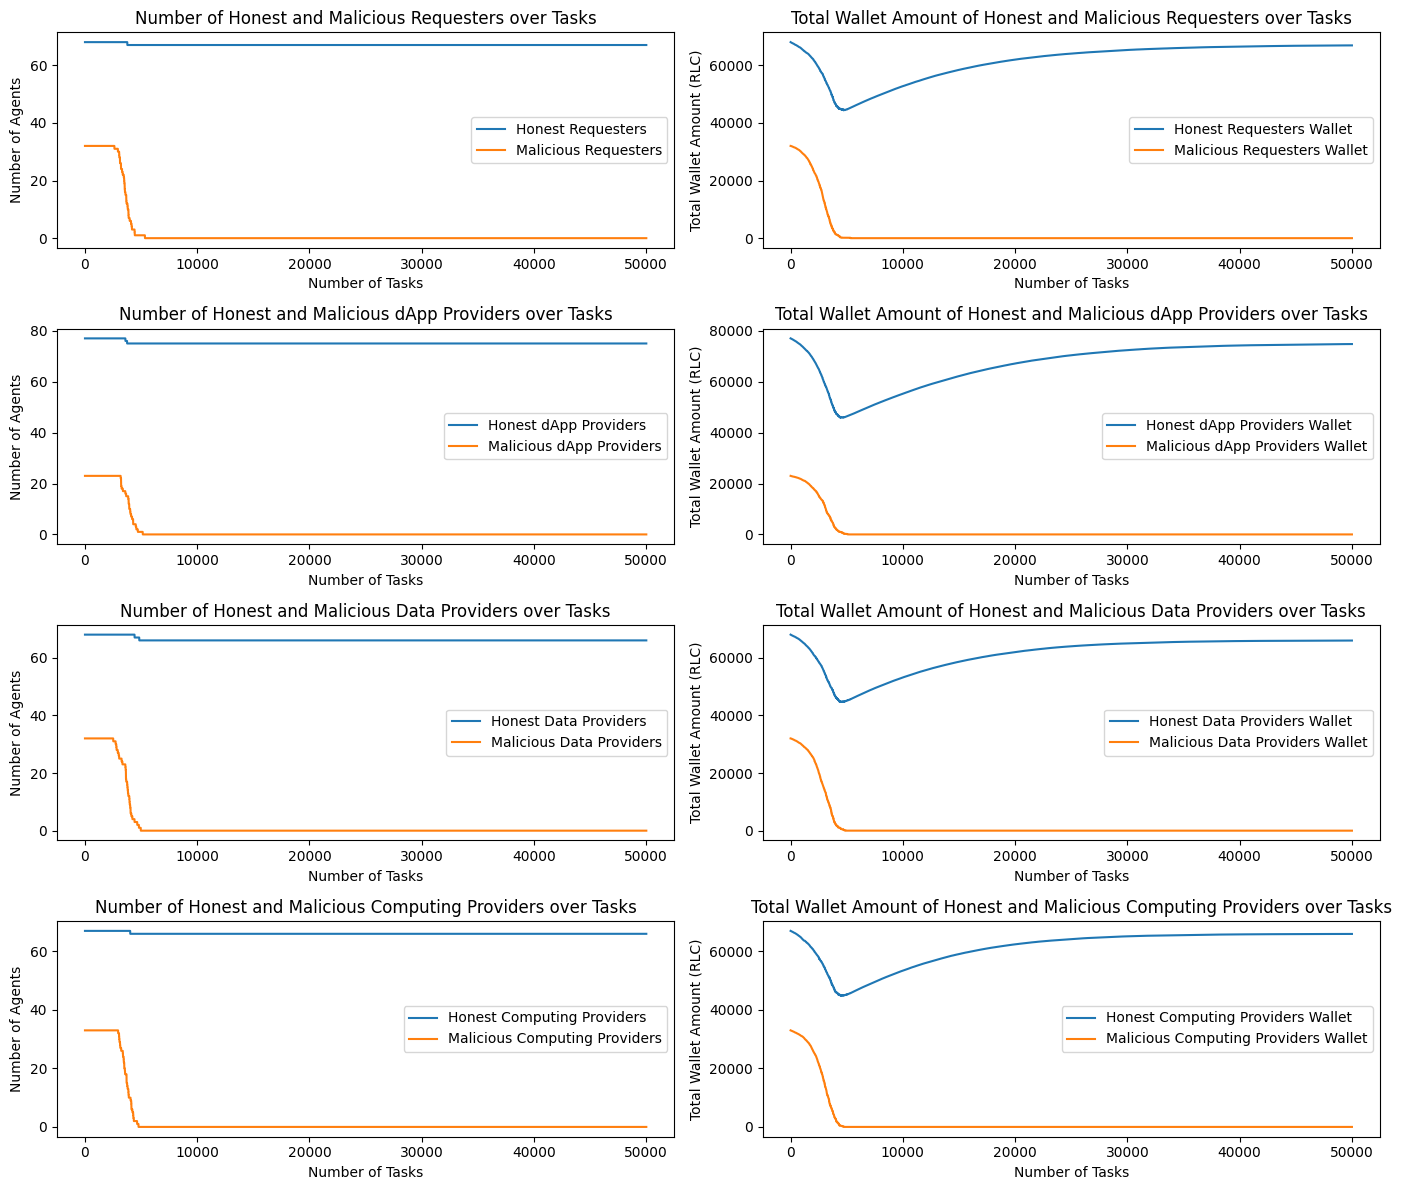

In [15]:
# Function to simulate a task round
def simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):

    # Check if pools are not empty
    if not requesters or not dapp_providers or not data_providers or not computing_providers:
        return False  # No task can be performed if any pool is empty

    # Randomly assign one agent from each pool to form a task group
    requester = random.choice(requesters)
    dapp_provider = random.choice(dapp_providers)
    data_provider = random.choice(data_providers)
    computing_provider = random.choice(computing_providers)

    # Determine prices randomly (1 to 100 RLC)
    dapp_price = random.randint(10, 100)
    data_price = random.randint(10, 100)
    computing_price = (dapp_price + data_price) * 0.75
    total_order_price = dapp_price + data_price + computing_price


    # Check if any agent in the task group is malicious
    task_failed = any(agent.is_malicious for agent in [requester, dapp_provider, data_provider, computing_provider])

    if task_failed:
        # Calculate slashing amounts
        slash_amount_requester = ( (STAKE_AMOUNT - requester.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_REQUESTER ) * computing_price
        slash_amount_dapp_provider = ( (STAKE_AMOUNT - dapp_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DAPP_PROVIDER ) * computing_price
        slash_amount_data_provider = ( (STAKE_AMOUNT - data_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DATA_PROVIDER ) * computing_price
        slash_amount_computing_provider = ( (STAKE_AMOUNT - computing_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_COMPUTING_PROVIDER ) * computing_price

        # Slash the agents
        requester.stake_pool -=  slash_amount_requester
        requester.slash_pool +=  slash_amount_requester
        dapp_provider.stake_pool -= slash_amount_dapp_provider
        dapp_provider.slash_pool += slash_amount_dapp_provider
        data_provider.stake_pool -= slash_amount_data_provider
        data_provider.slash_pool += slash_amount_data_provider
        computing_provider.stake_pool -= slash_amount_computing_provider
        computing_provider.slash_pool += slash_amount_computing_provider

        # Check if any agent's stake pool is empty
        if requester.stake_pool <= 0:
            print(f"BANNED REQUESTER: {requester.print_info()}")
            requesters.remove(requester)
        if dapp_provider.stake_pool <= 0:
            print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
            dapp_providers.remove(dapp_provider)
        if data_provider.stake_pool <= 0:
            print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
            data_providers.remove(data_provider)
        if computing_provider.stake_pool <= 0:
            print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
            computing_providers.remove(computing_provider)

    # Computing provider is not slashed but incurs the cost of computation as a penalty
    
    else:
        # Calculate reward amount
        reward_amount_requester = ( requester.stake_pool * REWARD_PERCENT_REQUESTER ) / STAKE_AMOUNT * requester.slash_pool
        reward_amount_dapp_provider = ( dapp_provider.stake_pool * REWARD_PERCENT_DAPP_PROVIDER ) / STAKE_AMOUNT * dapp_provider.slash_pool
        reward_amount_data_provider = ( data_provider.stake_pool * REWARD_PERCENT_DATA_PROVIDER ) / STAKE_AMOUNT * data_provider.slash_pool
        reward_amount_computing_provider = ( computing_provider.stake_pool * REWARD_PERCENT_COMPUTING_PROVIDER ) / STAKE_AMOUNT * computing_provider.slash_pool

        # Reward the agents
        requester.stake_pool +=  reward_amount_requester
        requester.slash_pool -=  reward_amount_requester
        dapp_provider.stake_pool += reward_amount_dapp_provider
        dapp_provider.slash_pool -= reward_amount_dapp_provider
        data_provider.stake_pool += reward_amount_data_provider
        data_provider.slash_pool -= reward_amount_data_provider
        computing_provider.stake_pool += reward_amount_computing_provider
        computing_provider.slash_pool -= reward_amount_computing_provider

    # Return the result of the task (success or failure)
    return not task_failed

# Define classes for agents
class Agent:
    def __init__(self, id, stake_pool, is_malicious):
        self.id = id
        self.stake_pool = stake_pool
        self.slash_pool = 0
        self.is_malicious = is_malicious

    def print_info(self):
        return f"Agent ID: {self.id}, Stake Pool: {self.stake_pool}, Slash Pool: {self.slash_pool}, Malicious: {self.is_malicious}"

# Initialize pools of agents
requesters = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_REQUESTER_RATIO) for i in range(NUM_REQUESTERS)]
dapp_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DAPP_PROVIDER_RATIO) for i in range(NUM_DAPP_PROVIDERS)]
data_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_DATA_PROVIDER_RATIO) for i in range(NUM_DATA_PROVIDERS)]
computing_providers = [Agent(i, STAKE_AMOUNT, random.random() < MALICIOUS_COMPUTING_PROVIDER_RATIO) for i in range(NUM_COMPUTING_PROVIDERS)]

# Track counts of honest and malicious actors over time
task_counts = list(range(1, TOTAL_TASKS + 1))
honest_requesters_count = []
malicious_requesters_count = []
honest_dapp_providers_count = []
malicious_dapp_providers_count = []
honest_data_providers_count = []
malicious_data_providers_count = []
honest_computing_providers_count = []
malicious_computing_providers_count = []

# Track wallet amounts of honest and malicious actors over time
honest_requesters_wallet = []
malicious_requesters_wallet = []
honest_dapp_providers_wallet = []
malicious_dapp_providers_wallet = []
honest_data_providers_wallet = []
malicious_data_providers_wallet = []
honest_computing_providers_wallet = []
malicious_computing_providers_wallet = []

# Simulate tasks
successful_tasks = 0
for _ in range(TOTAL_TASKS):
    # Count initial number of honest and malicious actors
    honest_requesters = sum(1 for requester in requesters if not requester.is_malicious)
    malicious_requesters = sum(1 for requester in requesters if requester.is_malicious)
    honest_dapp_providers = sum(1 for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    malicious_dapp_providers = sum(1 for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    honest_data_providers = sum(1 for data_provider in data_providers if not data_provider.is_malicious)
    malicious_data_providers = sum(1 for data_provider in data_providers if data_provider.is_malicious)
    honest_computing_providers = sum(1 for computing_provider in computing_providers if not computing_provider.is_malicious)
    malicious_computing_providers = sum(1 for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_count.append(honest_requesters)
    malicious_requesters_count.append(malicious_requesters)
    honest_dapp_providers_count.append(honest_dapp_providers)
    malicious_dapp_providers_count.append(malicious_dapp_providers)
    honest_data_providers_count.append(honest_data_providers)
    malicious_data_providers_count.append(malicious_data_providers)
    honest_computing_providers_count.append(honest_computing_providers)
    malicious_computing_providers_count.append(malicious_computing_providers)

    # Track total wallet amounts
    total_wallet_honest_requesters = sum(requester.stake_pool for requester in requesters if not requester.is_malicious)
    total_wallet_malicious_requesters = sum(requester.stake_pool for requester in requesters if requester.is_malicious)
    total_wallet_honest_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if not dapp_provider.is_malicious)
    total_wallet_malicious_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if dapp_provider.is_malicious)
    total_wallet_honest_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if not data_provider.is_malicious)
    total_wallet_malicious_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if data_provider.is_malicious)
    total_wallet_honest_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if not computing_provider.is_malicious)
    total_wallet_malicious_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if computing_provider.is_malicious)

    honest_requesters_wallet.append(total_wallet_honest_requesters)
    malicious_requesters_wallet.append(total_wallet_malicious_requesters)
    honest_dapp_providers_wallet.append(total_wallet_honest_dapp_providers)
    malicious_dapp_providers_wallet.append(total_wallet_malicious_dapp_providers)
    honest_data_providers_wallet.append(total_wallet_honest_data_providers)
    malicious_data_providers_wallet.append(total_wallet_malicious_data_providers)
    honest_computing_providers_wallet.append(total_wallet_honest_computing_providers)
    malicious_computing_providers_wallet.append(total_wallet_malicious_computing_providers)

    if simulate_task_round(requesters, dapp_providers, data_providers, computing_providers):
        successful_tasks += 1

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Plot results
plt.figure(figsize=(14, 12))

plt.subplot(421)
plt.plot(task_counts, honest_requesters_count, label='Honest Requesters')
plt.plot(task_counts, malicious_requesters_count, label='Malicious Requesters')
plt.title('Number of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(422)
plt.plot(task_counts, honest_requesters_wallet, label='Honest Requesters Wallet')
plt.plot(task_counts, malicious_requesters_wallet, label='Malicious Requesters Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(423)
plt.plot(task_counts, honest_dapp_providers_count, label='Honest dApp Providers')
plt.plot(task_counts, malicious_dapp_providers_count, label='Malicious dApp Providers')
plt.title('Number of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(424)
plt.plot(task_counts, honest_dapp_providers_wallet, label='Honest dApp Providers Wallet')
plt.plot(task_counts, malicious_dapp_providers_wallet, label='Malicious dApp Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(425)
plt.plot(task_counts, honest_data_providers_count, label='Honest Data Providers')
plt.plot(task_counts, malicious_data_providers_count, label='Malicious Data Providers')
plt.title('Number of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(426)
plt.plot(task_counts, honest_data_providers_wallet, label='Honest Data Providers Wallet')
plt.plot(task_counts, malicious_data_providers_wallet, label='Malicious Data Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(427)
plt.plot(task_counts, honest_computing_providers_count, label='Honest Computing Providers')
plt.plot(task_counts, malicious_computing_providers_count, label='Malicious Computing Providers')
plt.title('Number of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(428)
plt.plot(task_counts, honest_computing_providers_wallet, label='Honest Computing Providers Wallet')
plt.plot(task_counts, malicious_computing_providers_wallet, label='Malicious Computing Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.tight_layout()
plt.show()